# WeightWatcher ResNet

https://calculationconsulting.com


### Analysis of pyTorch ResNet Models

ResNet, with the same number of layers,  is a much smaller model than VGG, with 20X less parameters.

We will see the power law exponents $\alpha$ approach 2 (or less) and do not vary much between layers until the very end, where the power law model breaks down and we have bulk+spikes.  Compare this to VGG, where $\alpha$ immediately increases with layer depth

Moreover, the average exponent $\langle\alpha\langle$ decreaes with test error, whereas for the VGG series, only the weighted alpha $\hat{\alpha}$  decreases with test error.


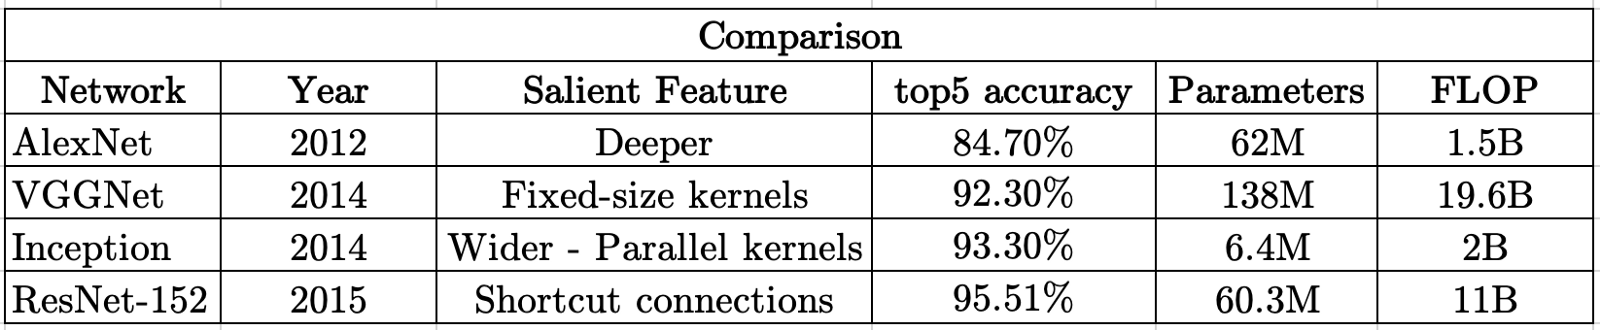

In [1]:
from IPython.display import Image
Image(filename='CV-models.png',width=800, height=400)

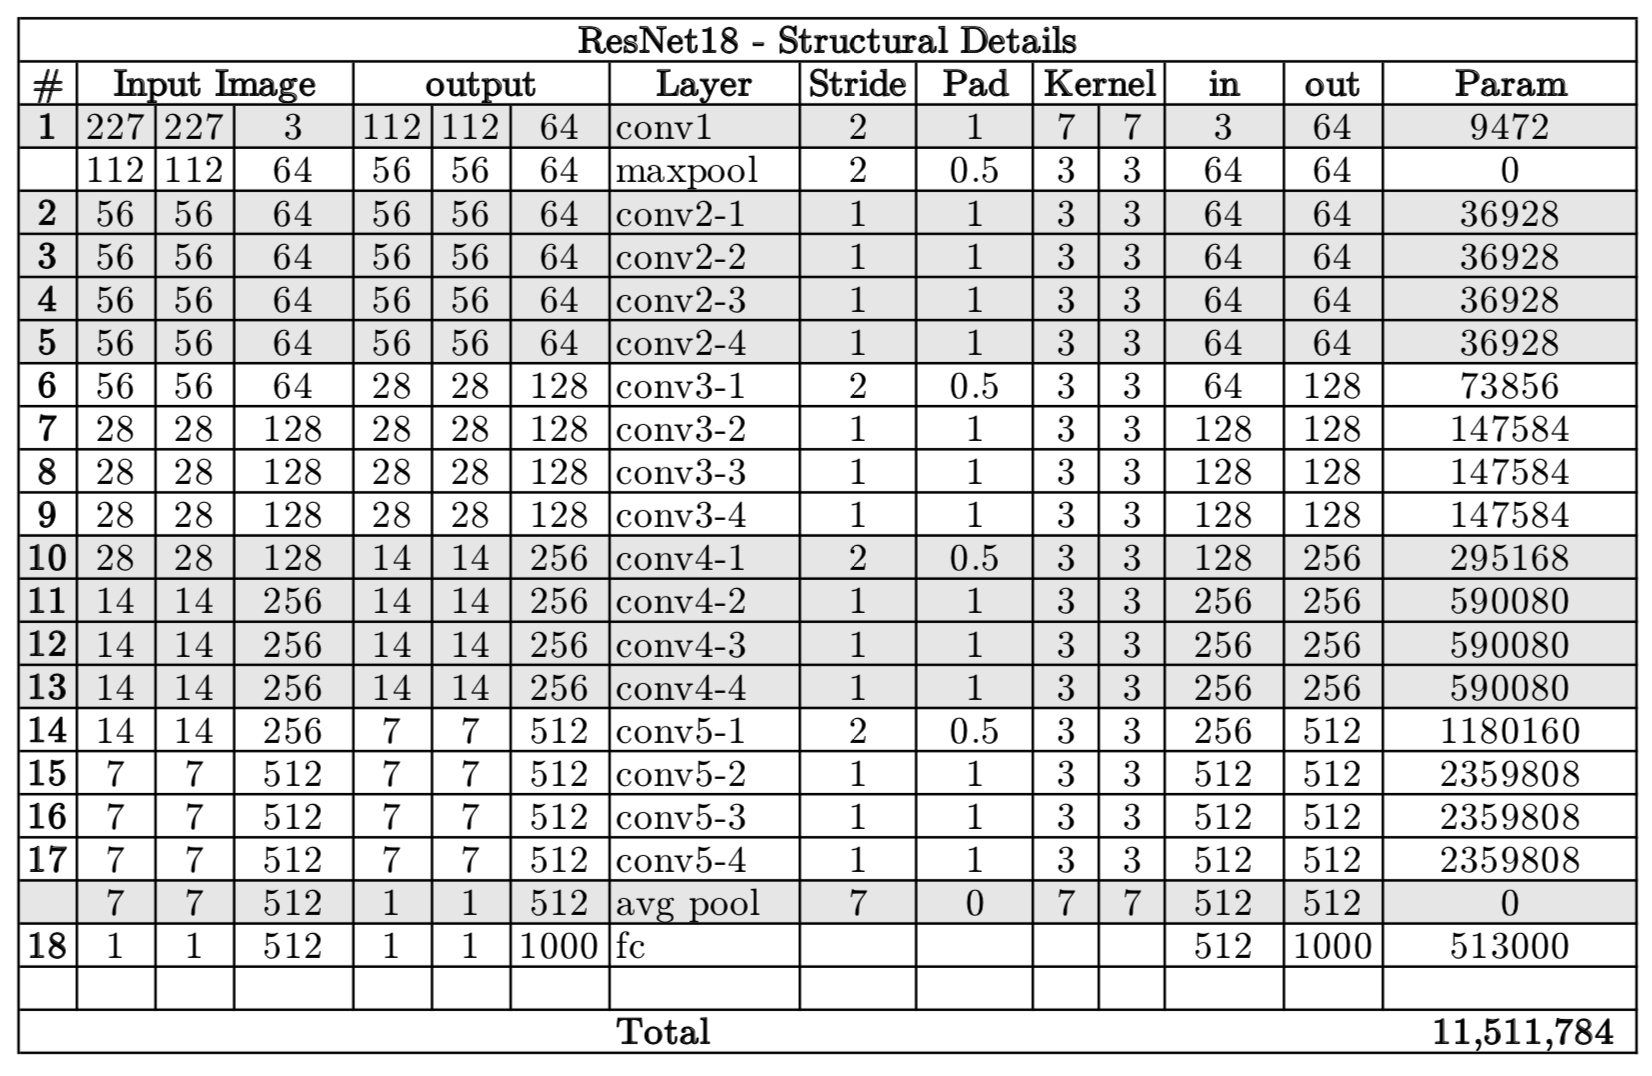

In [2]:
Image(filename='resnet18.png',width=800, height=400)

## Comparison of VGG and ResNet

https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

### Key Idea:  Residual Connections

Improves gradient / information flow through the network

Because of this, there are much deeper ResNet variants.  In fact, some researchers have trained ResNet variants with 1001 layers!

## Results

In contrast to the VGG series, the ResNet Average Alpha $\langle\alpha\rangle$ is positively correlated with the Test Error:  smaller average alpha corresponds to better generalization.  Moreover, the layer $\alpha$ are fairly constant, and near $2.0$, for at least $3/4$ of the network

## Calculations of Results

In [3]:
# Suppress the powerlaw package warnings
# "powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide"
# "powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide"
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [4]:
import numpy as np
import pandas as pd

from tqdm import tqdm 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Import WeightWatcher

set custom Logging at WARN Level

In [5]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


Using TensorFlow backend.


'0.2.5'

###  Helper Notebook to make Plots


In [6]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

In [7]:

series_name = 'ResNet'
all_names = [ 'resnet18', 'resnet34', 'resnet50', 'resnet101','resnet152']

colors = ['blue', 'green', 'teal', 'orange', 'red']


In [8]:


all_models = []
all_models.append(models.resnet18(pretrained=True))
all_models.append(models.resnet34(pretrained=True))
all_models.append(models.resnet50(pretrained=True))
all_models.append(models.resnet101(pretrained=True))
all_models.append(models.resnet152(pretrained=True))




### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html

<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-odd"><td><p>ResNet-18</p></td>
<td><p>30.24</p></td>
<td><p>10.92</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-34</p></td>
<td><p>26.70</p></td>
<td><p>8.58</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-50</p></td>
<td><p>23.85</p></td>
<td><p>7.13</p></td>
</tr>
<tr class="row-even"><td><p>ResNet-101</p></td>
<td><p>22.63</p></td>
<td><p>6.44</p></td>
</tr>
<tr class="row-odd"><td><p>ResNet-152</p></td>
<td><p>21.69</p></td>
<td><p>5.94</p></td>
</tr>

</tbody>
</table>
</pre>

In [9]:
top1_errors= {
    
    "resnet18": 30.24,
    "resnet34": 26.70,
    "resnet50": 23.85,
    "resnet101": 22.63,
    "resnet152": 21.69 

}

In [10]:
top5_errors= {
    
    "resnet18": 10.92,
    "resnet34": 8.58,
    "resnet50": 7.13,
    "resnet101": 6.44,
    "resnet152": 5.94    

}

## Run WeightWatcher 

### collect summary and details (as dataframes) for all models

In [11]:
all_details = []
all_summaries = []
for im, name in enumerate(tqdm(all_names)):
    watcher = ww.WeightWatcher(model=all_models[im], logger=logger)
    results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True)

    summary =  watcher.get_summary()
    all_summaries.append(summary)
    details  = watcher.get_details(results=results)
    details.drop(columns=['slice', 'slice_count'], inplace=True)
    details.dropna(inplace=True)
    details['NxM'] = pd.to_numeric(details.N * details.M)

    all_details.append(details)

100%|██████████| 5/5 [14:28<00:00, 173.67s/it]


In [12]:
plt.rcParams.update({'font.size': 20})
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

In [13]:
first_n_last_ids = [0, len(all_details)-1]

saving img/ResNet_lognorm_accs.png


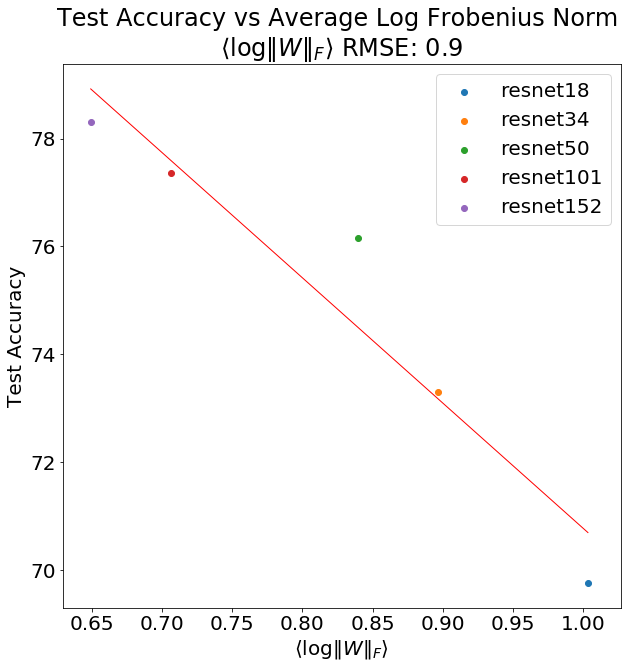

saving img/ResNet_alpha_accs.png


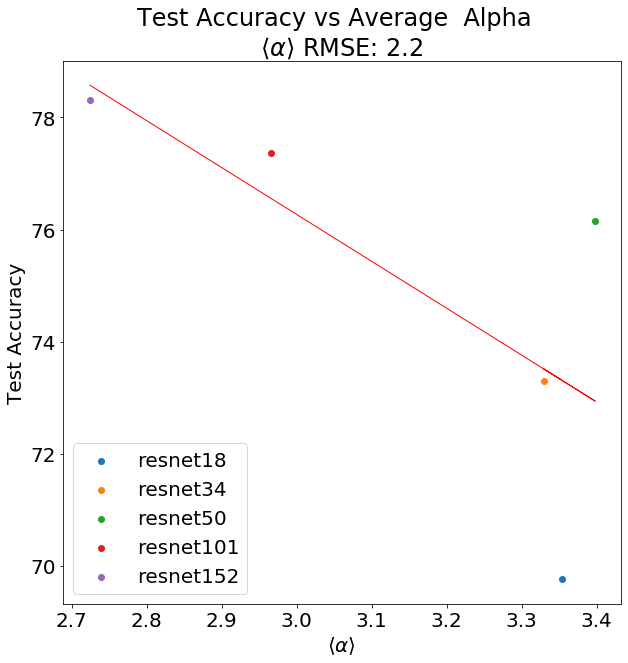

saving img/ResNet_alpha_weighted_accs.png


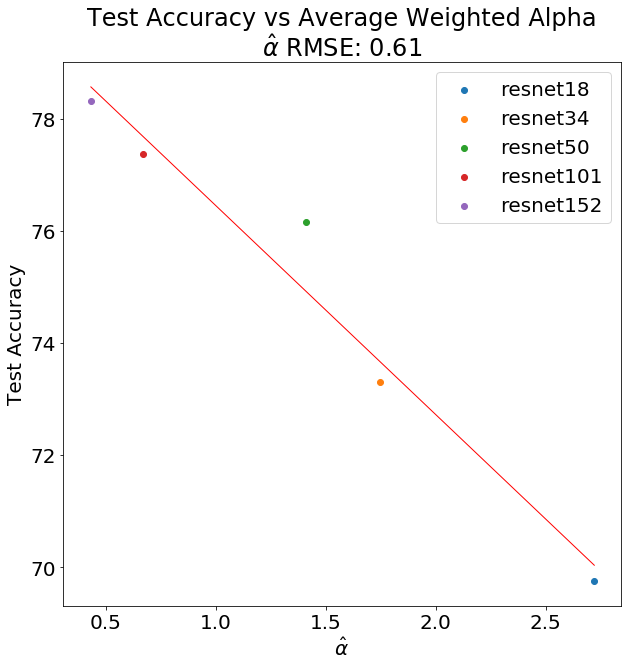

saving img/ResNet_spectralnorm_accs.png


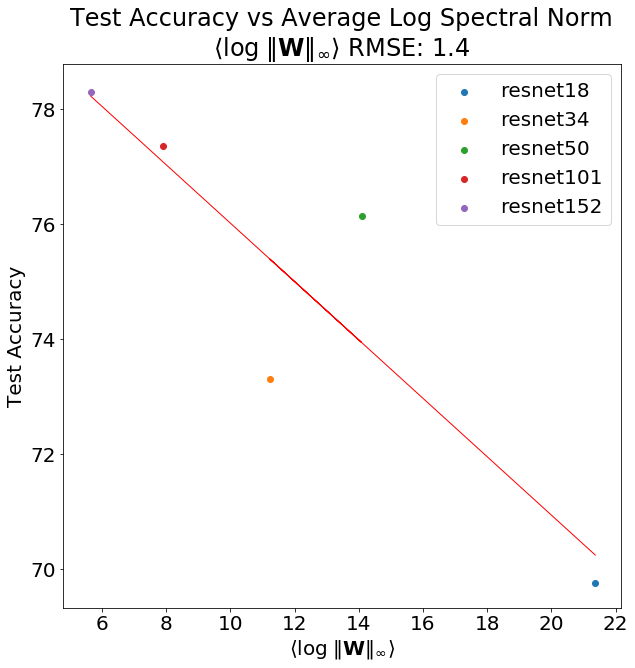

saving img/ResNet_softranklog_accs.png


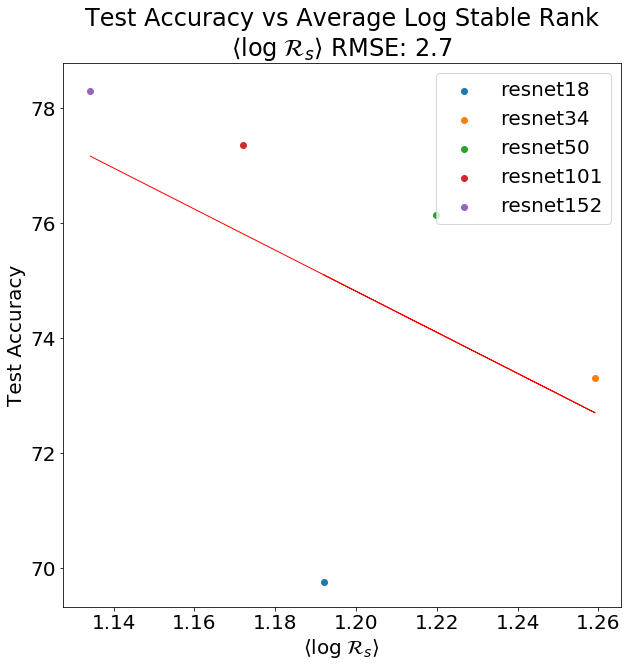

saving img/ResNet_softrank_mp_accs.png


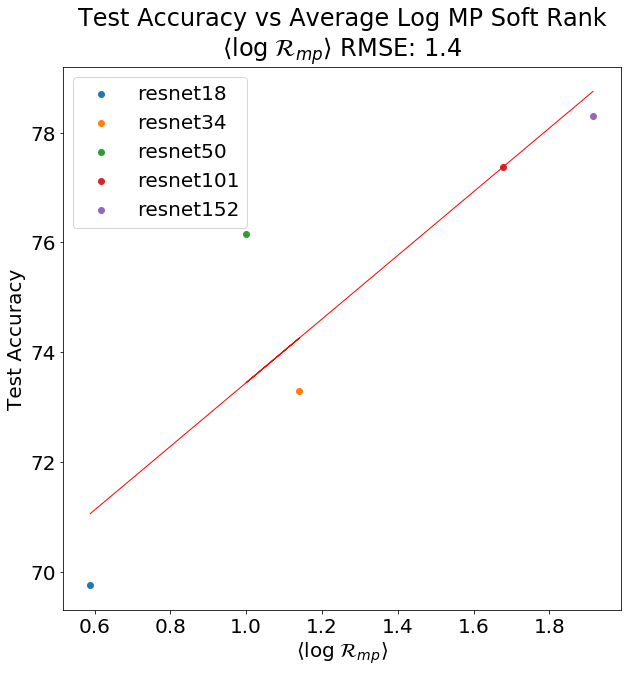

saving img/ResNet_logpnorm_accs.png


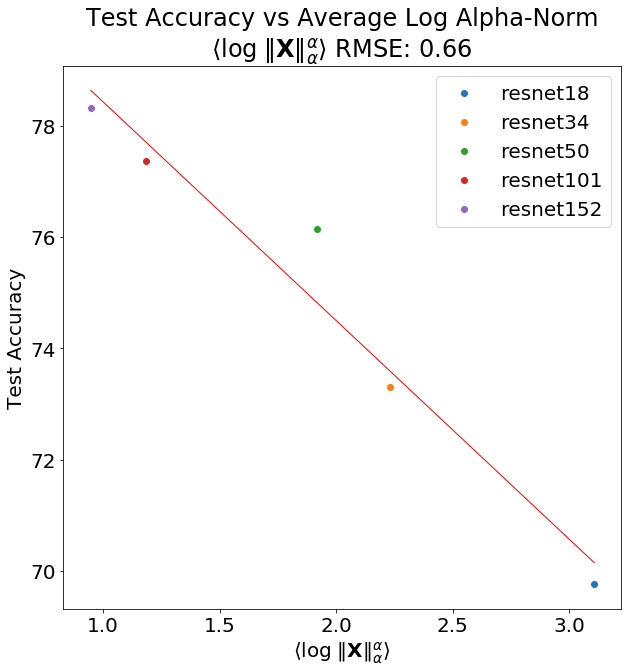

In [14]:
MP.plot_all_metrics_vs_test_accuracies( \
    series_name, all_names, colors, all_summaries, all_details, top1_errors)

saving img/ResNet_all_lognorm_hist.png


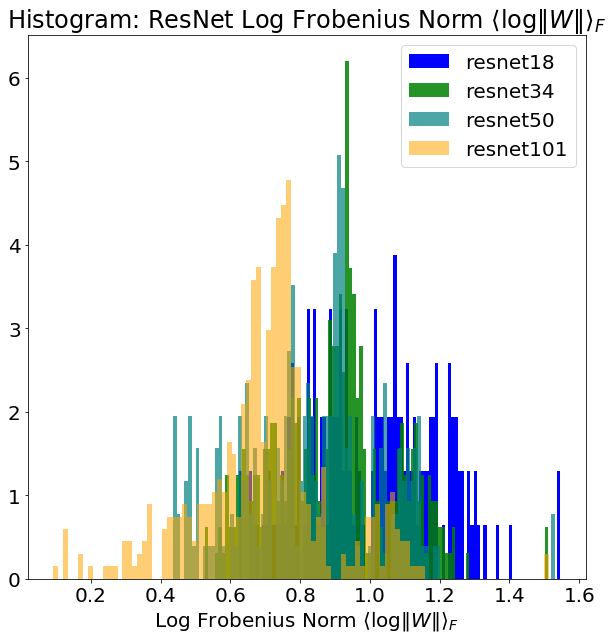

saving img/ResNet_fnl_lognorm_hist.png


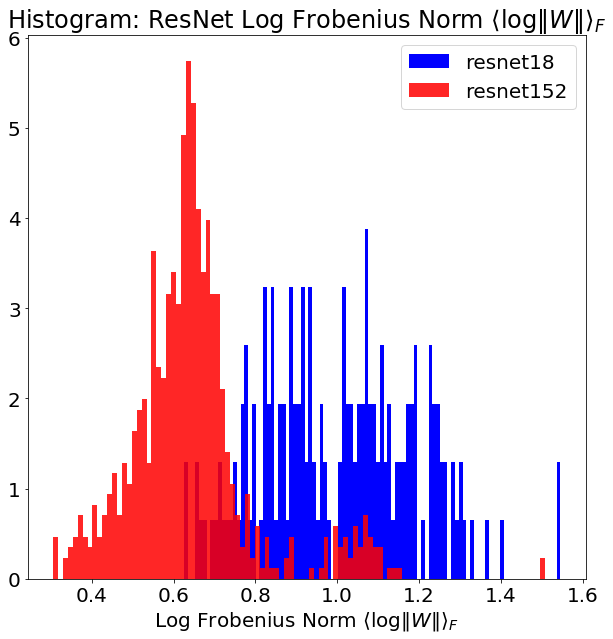

saving img/ResNet_all_alpha_hist.png


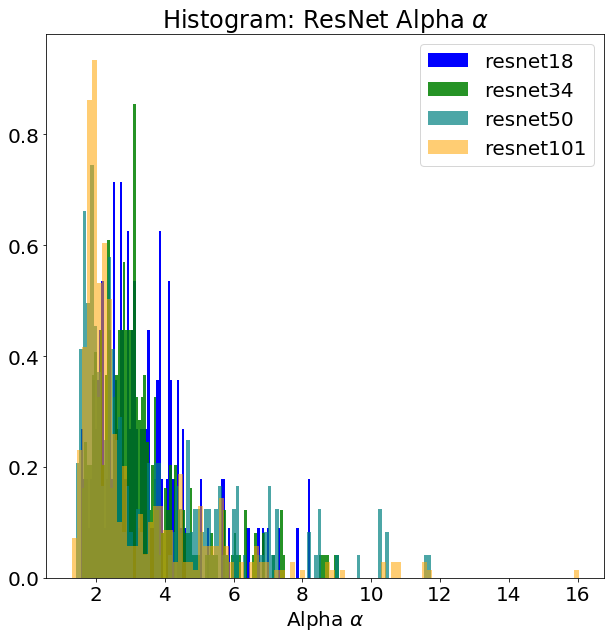

saving img/ResNet_fnl_alpha_hist.png


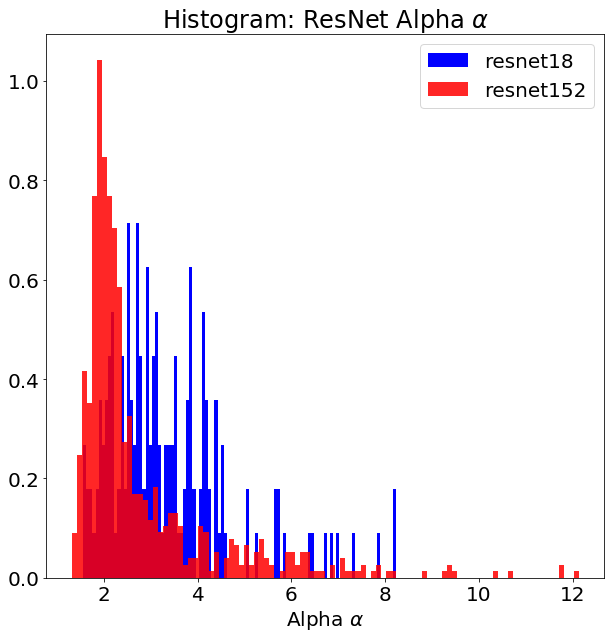

saving img/ResNet_all_alpha_weighted_hist.png


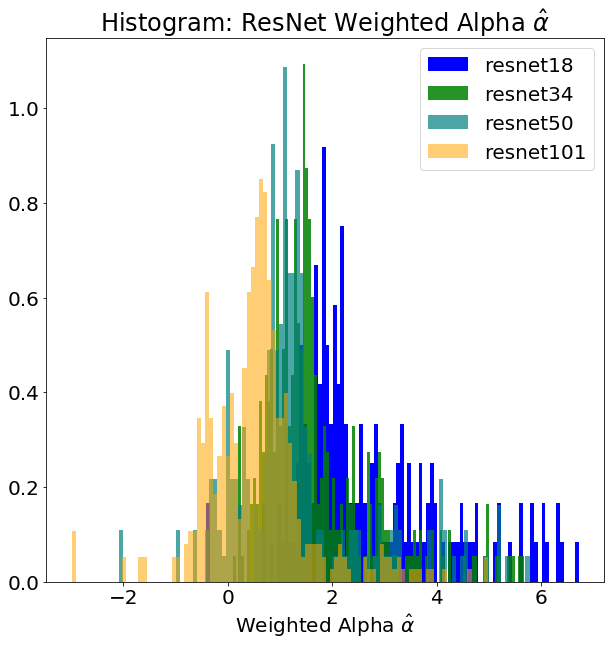

saving img/ResNet_fnl_alpha_weighted_hist.png


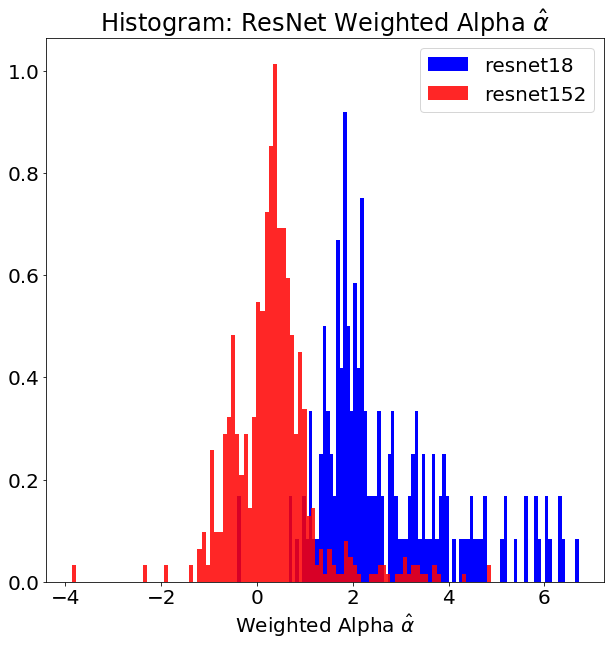

saving img/ResNet_all_softranklog_hist.png


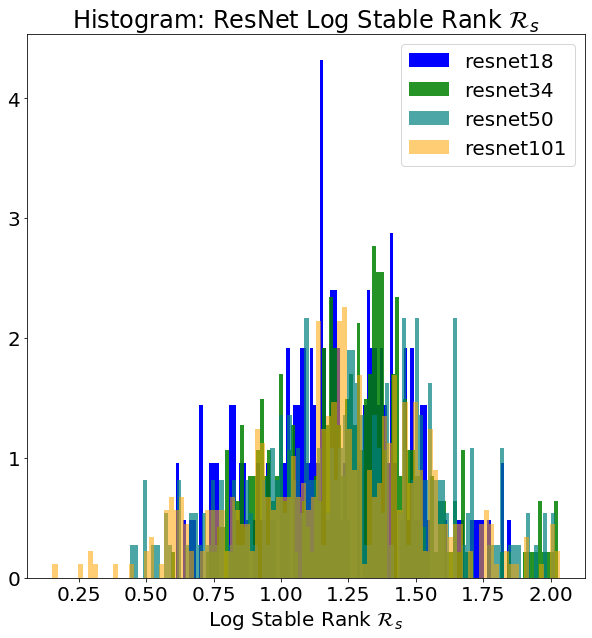

saving img/ResNet_fnl_softranklog_hist.png


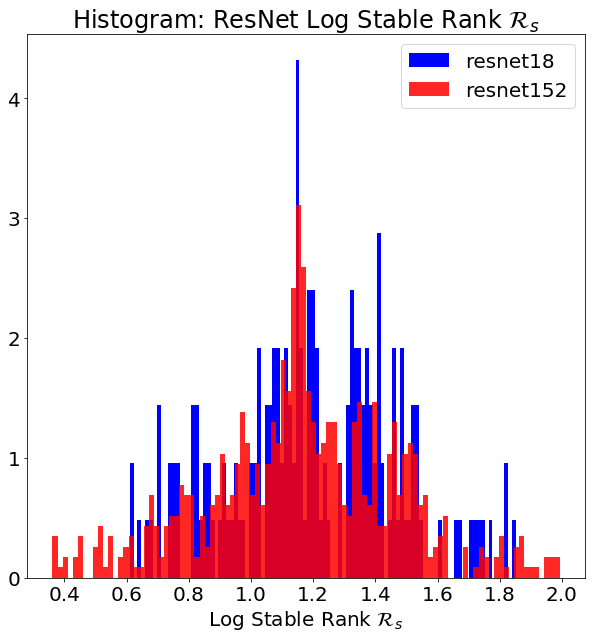

saving img/ResNet_all_spectralnorm_hist.png


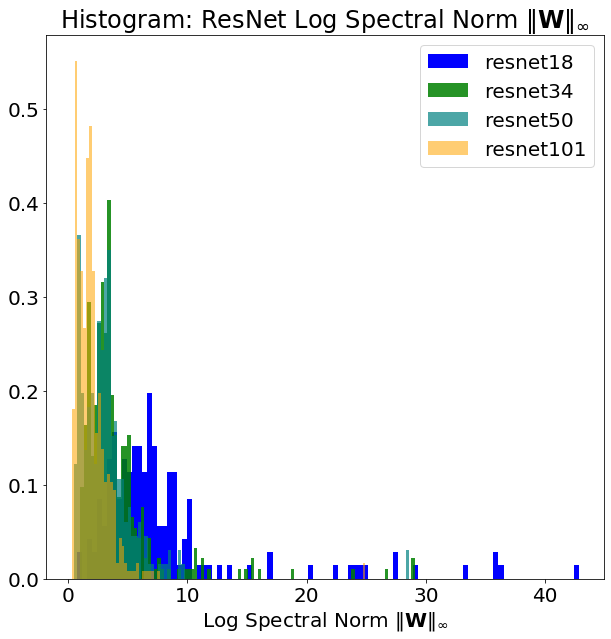

saving img/ResNet_fnl_spectralnorm_hist.png


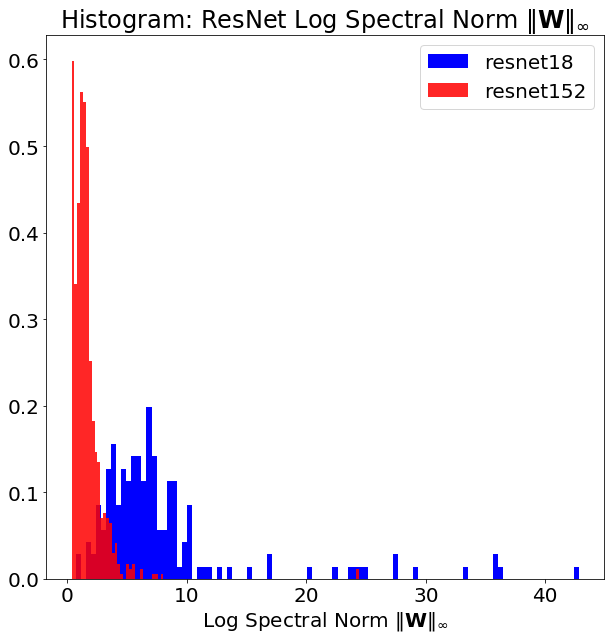

saving img/ResNet_all_softrank_mp_hist.png


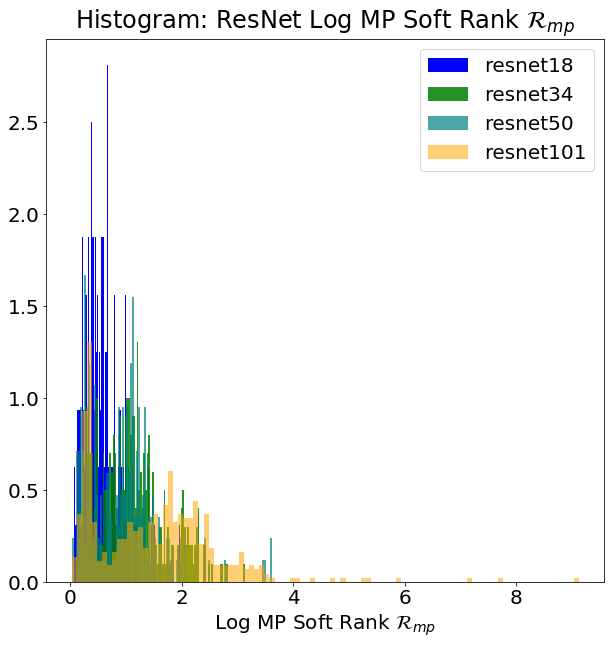

saving img/ResNet_fnl_softrank_mp_hist.png


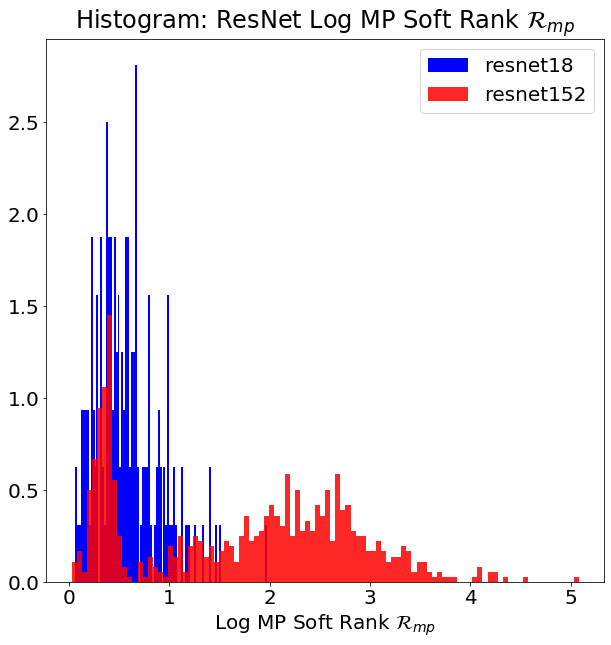

saving img/ResNet_all_logpnorm_hist.png


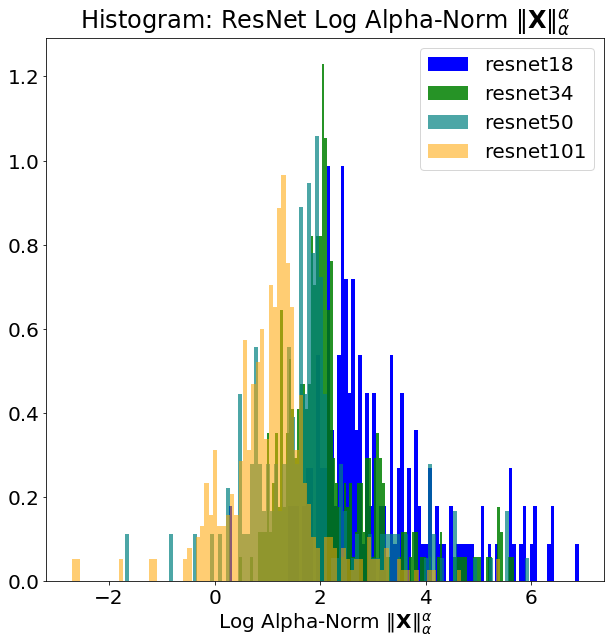

saving img/ResNet_fnl_logpnorm_hist.png


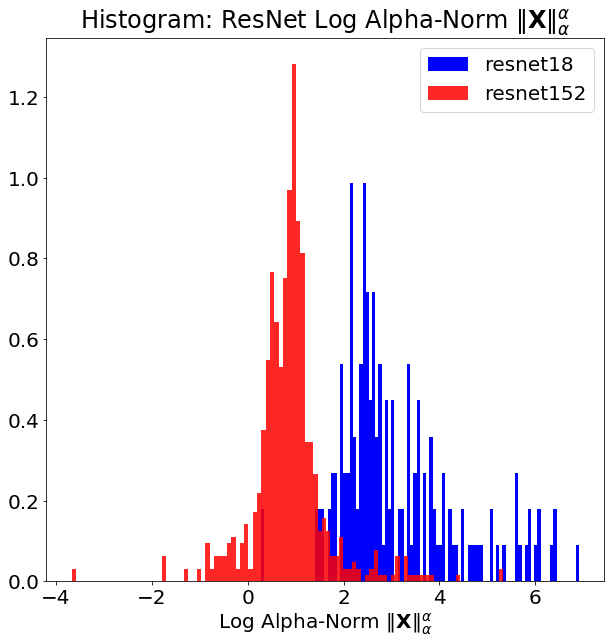

In [15]:
MP.plot_all_metric_histograms( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)

saving img/ResNet_all_lognorm_depth.png


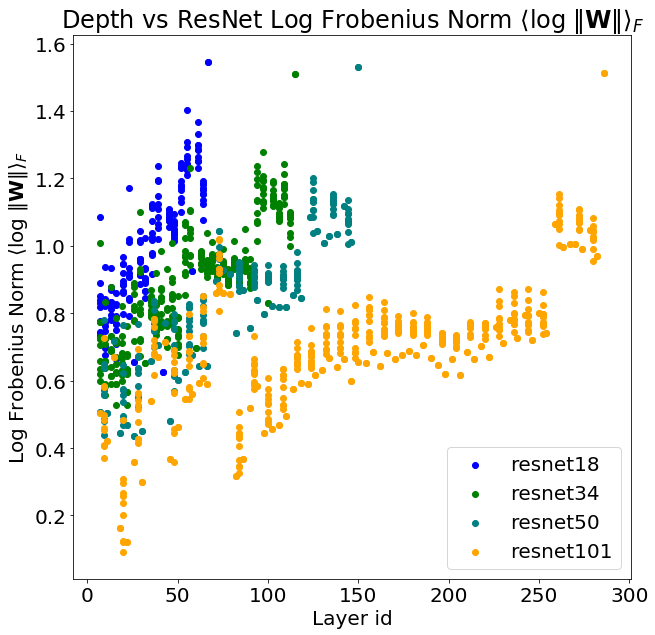

saving img/ResNet_fnl_lognorm_depth.png


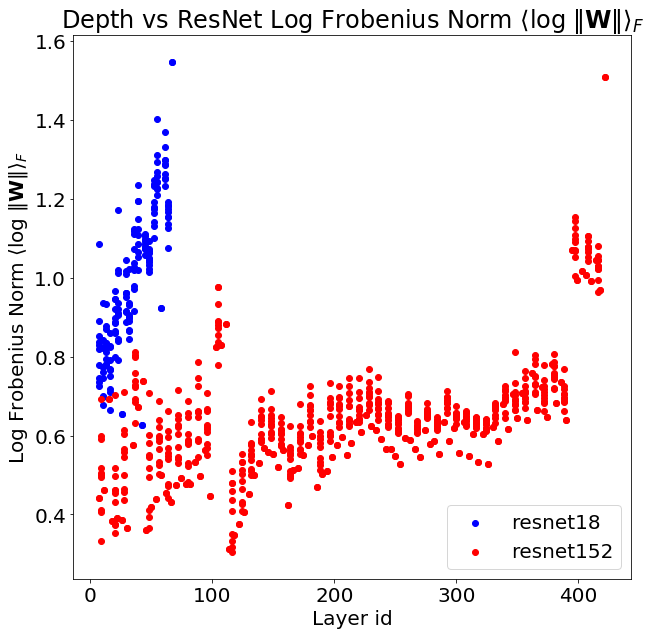

saving img/ResNet_all_alpha_depth.png


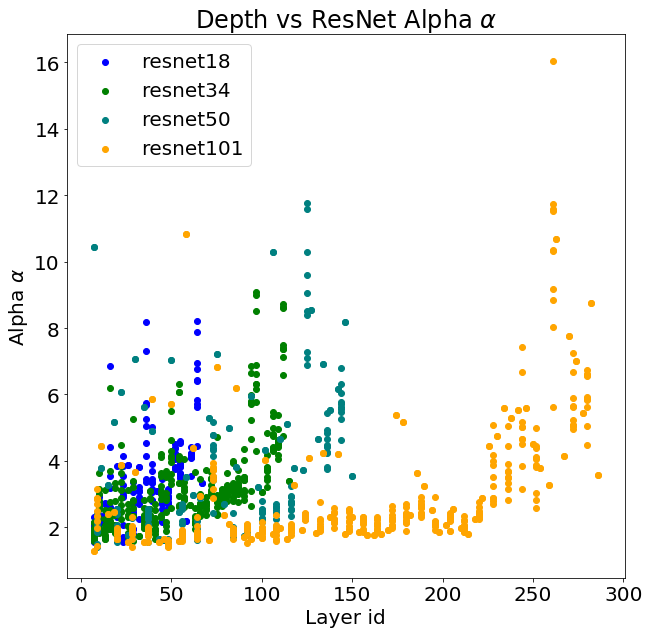

saving img/ResNet_fnl_alpha_depth.png


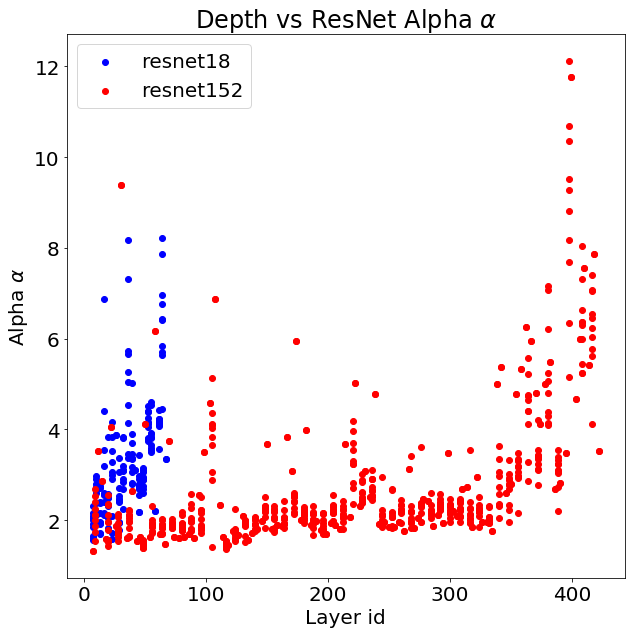

saving img/ResNet_all_alpha_weighted_depth.png


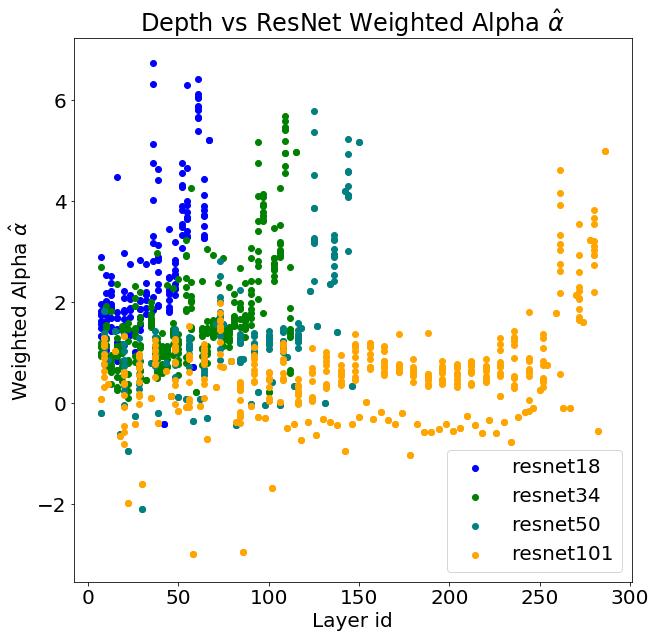

saving img/ResNet_fnl_alpha_weighted_depth.png


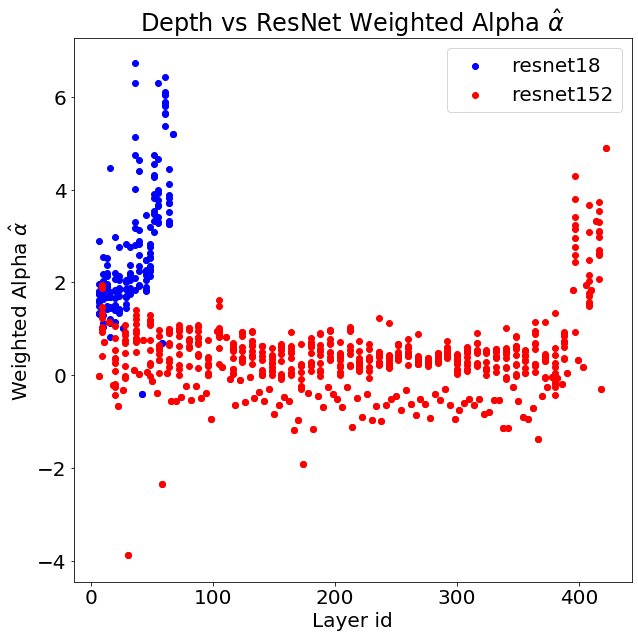

saving img/ResNet_all_softranklog_depth.png


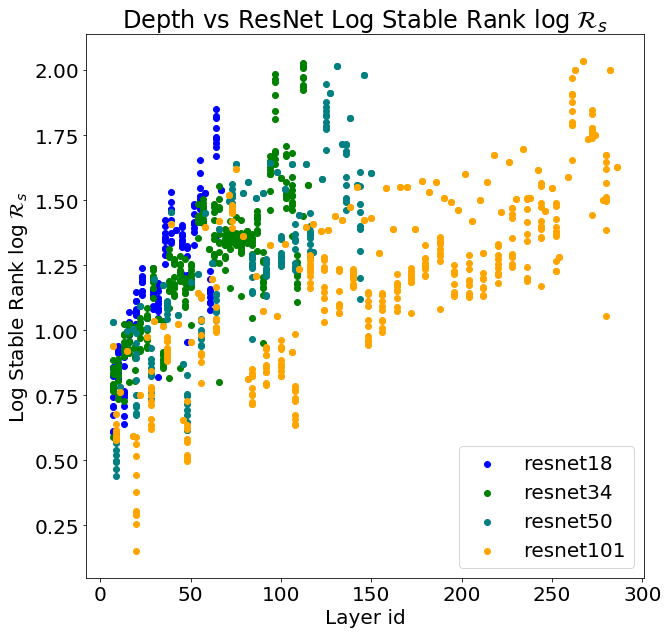

saving img/ResNet_fnl_softranklog_depth.png


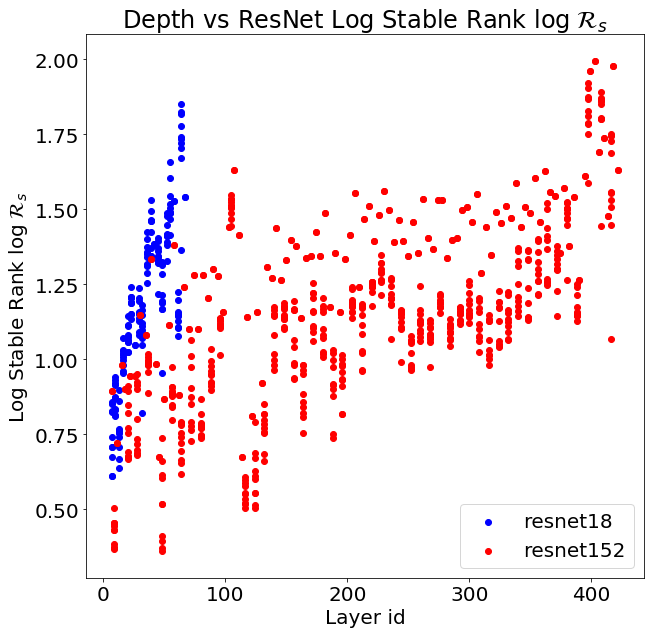

saving img/ResNet_all_spectralnorm_depth.png


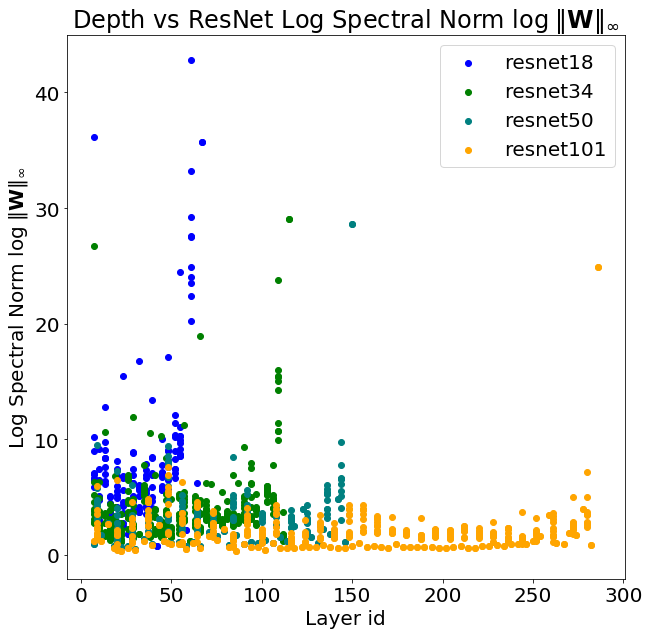

saving img/ResNet_fnl_spectralnorm_depth.png


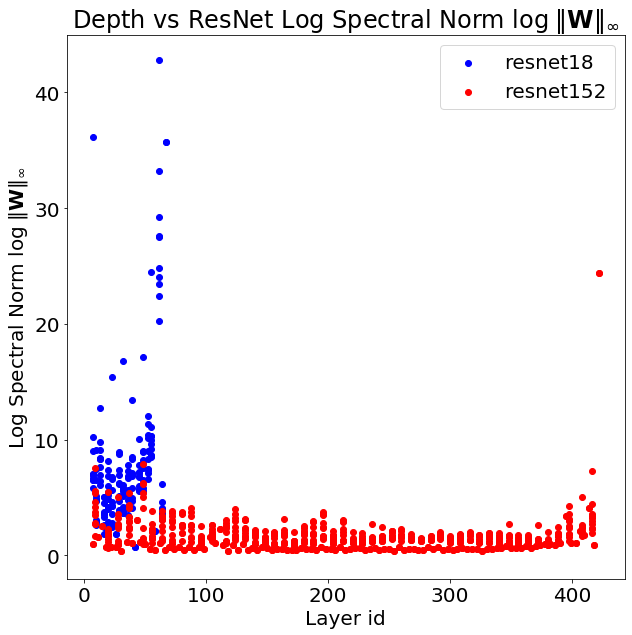

saving img/ResNet_all_softrank_mp_depth.png


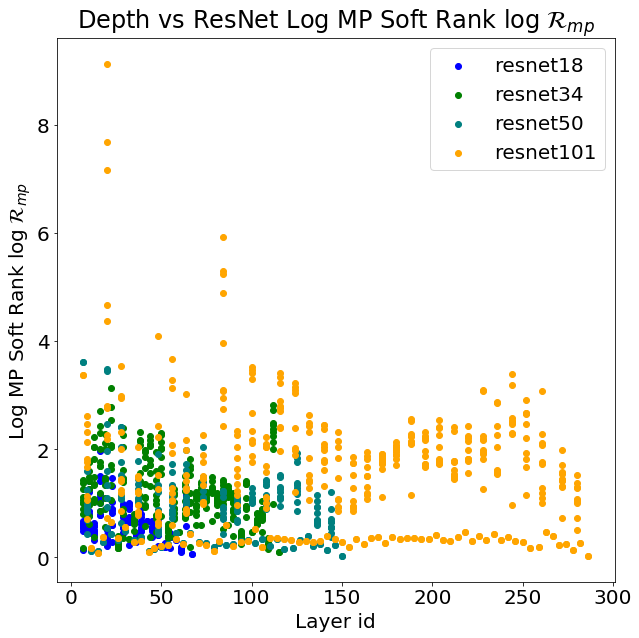

saving img/ResNet_fnl_softrank_mp_depth.png


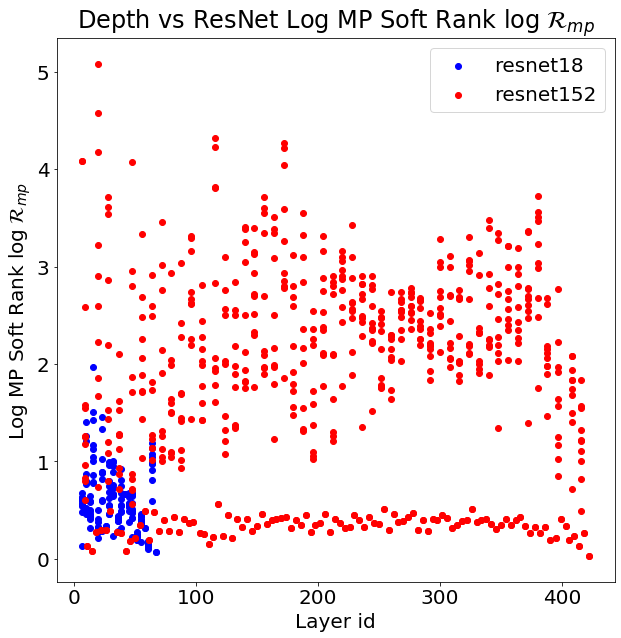

saving img/ResNet_all_logpnorm_depth.png


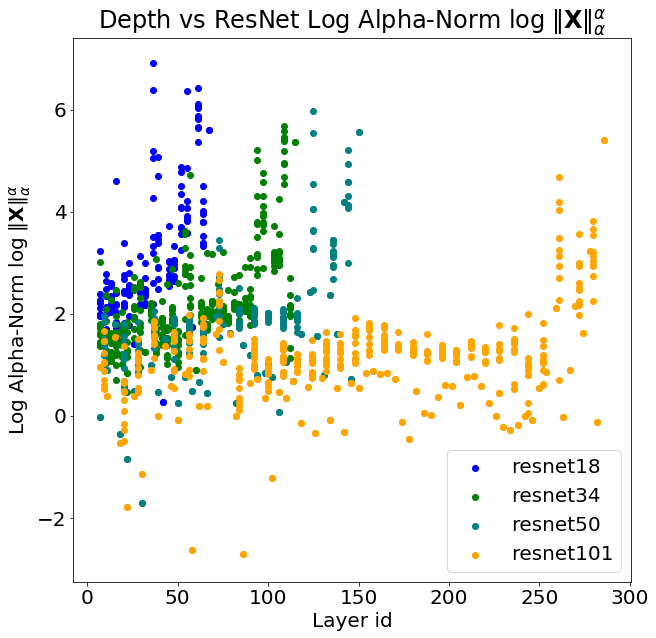

saving img/ResNet_fnl_logpnorm_depth.png


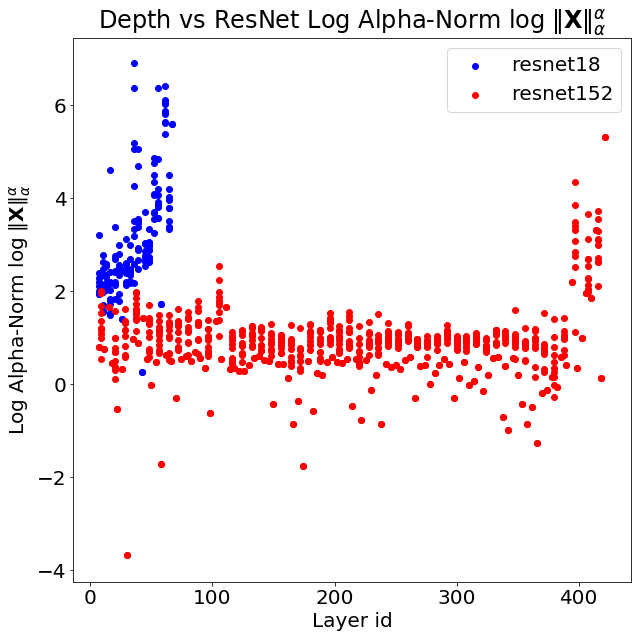

In [16]:
MP.plot_all_metric_vs_depth( \
    series_name, all_names, colors, all_summaries, all_details,  first_n_last_ids)